# Train, debug & profile Machine Learning Models
In this notebook, we use sagemaker to train models

## Table of contents
___
1. sob
2. al3ab
3. fadlek

In [2]:
import os
import sagemaker
import logging
import boto3
import time
import pandas as pd
import json
import botocore
from botocore.exceptions import ClientError


# ========================== low-level service client of the boto3 session ==========================
config = botocore.config.Config(user_agent_extra='bedissj-1699438736259')


sm = boto3.client(service_name='sagemaker', 
                  config=config)

sm_runtime = boto3.client('sagemaker-runtime',
                          config=config)

sess = sagemaker.Session(sagemaker_client=sm,
                         sagemaker_runtime_client=sm_runtime)

bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


# 1. Training a custom SKLearn estimator
___

In [3]:
churn_mon1 = 1
churn_mon2 = 2

n_estimators = 7
max_depth = 3
criterion = 'gini'
random_state = 2023

train_data_s3_uri = 's3://{}/sagemaker-scikit-learn-2023-11-13-11-46-50-760/output/bank-churn-train/'.format(bucket)
validation_data_s3_uri = 's3://{}/sagemaker-scikit-learn-2023-11-13-11-46-50-760/output/bank-churn-validation/'.format(bucket)
FRAMEWORK_VERSION = '1.0-1'
instance_type = 'ml.m5.large'
instance_count = 1

In [4]:
!aws s3 ls $train_data_s3_uri

2023-11-13 12:55:11    1187284 BankChurners.csv


In [5]:
!aws s3 ls $validation_data_s3_uri

2023-11-13 12:55:11     136670 BankChurners.csv


In [6]:
hyperparameters_mon1 = {
    'churn_month': churn_mon1,
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'criterion': criterion,
    'random_state': random_state
}

In [7]:
hyperparameters_mon2 = {
    'churn_month': churn_mon2,
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'criterion': criterion,
    'random_state': random_state
}

In [8]:
metric_definitions = [
    {'Name': 'validation:precision', 'Regex': 'val_precision: ([0-9.]+)'},
    {'Name': 'validation:recall', 'Regex': 'val_recall: ([0-9.]+)'},
    {'Name': 'validation:f1Score', 'Regex': 'val_f1score: ([0-9.]+)'},
    {'Name': 'validation:ROCAUC', 'Regex': 'val_roc_auc: ([0-9.]+)'},
    {'Name': 'validation:accuracy', 'Regex': 'val_accuracy: ([0-9.]+)'}
]

In [9]:
from sagemaker.inputs import TrainingInput


data_channels = {
    'train': TrainingInput(s3_data=train_data_s3_uri),
    'validation': TrainingInput(s3_data=validation_data_s3_uri)
}

In [46]:
from sagemaker.sklearn.estimator import SKLearn


sklearn_estimator_mon1 = SKLearn(
    entry_point='train.py',
    framework_version=FRAMEWORK_VERSION,
    instance_count=instance_count,
    instance_type=instance_type,
    role=role,
    metric_definitions=metric_definitions,
    hyperparameters=hyperparameters_mon1,
)


sklearn_estimator_mon2 = SKLearn(
    entry_point='train.py',
    framework_version=FRAMEWORK_VERSION,
    instance_count=instance_count,
    instance_type=instance_type,
    role=role,
    metric_definitions=metric_definitions,
    hyperparameters=hyperparameters_mon2,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [47]:
sklearn_estimator_mon1.fit(
    inputs=data_channels,
    wait=False,
    logs='All'
)

sklearn_estimator_mon2.fit(
    inputs=data_channels,
    wait=False,
    logs='All'
)

INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2023-11-17-06-55-37-105


Using provided s3_resource


INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2023-11-17-06-55-37-897


Using provided s3_resource


In [32]:
# sklearn_estimator_mon1.latest_training_job.describe().keys()

In [49]:
from pprint import pprint


for estimator in [sklearn_estimator_mon1, sklearn_estimator_mon2]:
    training_job = estimator.latest_training_job

    print(training_job.describe()['TrainingJobName'])
    print(training_job.describe()['TrainingJobStatus'])
    print(training_job.describe()['SecondaryStatus'])
    pprint(training_job.describe()['HyperParameters'])
    pprint(training_job.describe()['AlgorithmSpecification'])
    print('----------------------------------------------\n')

sagemaker-scikit-learn-2023-11-17-06-55-37-105
Completed
Completed
{'churn_month': '1',
 'criterion': '"gini"',
 'max_depth': '3',
 'n_estimators': '7',
 'random_state': '2023',
 'sagemaker_container_log_level': '20',
 'sagemaker_job_name': '"sagemaker-scikit-learn-2023-11-17-06-55-37-105"',
 'sagemaker_program': '"train.py"',
 'sagemaker_region': '"eu-west-3"',
 'sagemaker_submit_directory': '"s3://sagemaker-eu-west-3-668303144976/sagemaker-scikit-learn-2023-11-17-06-55-37-105/source/sourcedir.tar.gz"'}
{'EnableSageMakerMetricsTimeSeries': False,
 'MetricDefinitions': [{'Name': 'validation:precision',
                        'Regex': 'val_precision: ([0-9.]+)'},
                       {'Name': 'validation:recall',
                        'Regex': 'val_recall: ([0-9.]+)'},
                       {'Name': 'validation:f1Score',
                        'Regex': 'val_f1score: ([0-9.]+)'},
                       {'Name': 'validation:ROCAUC',
                        'Regex': 'val_roc_auc: ([

In [50]:
for estimator in [sklearn_estimator_mon1, sklearn_estimator_mon2]:
    training_job = estimator.latest_training_job
    
    print(training_job.describe()['TrainingJobName'])
    pprint(training_job.describe()['InputDataConfig'])
    pprint(training_job.describe()['OutputDataConfig'])
    print('----------------------------------------\n')

sagemaker-scikit-learn-2023-11-17-06-55-37-105
[{'ChannelName': 'train',
  'CompressionType': 'None',
  'DataSource': {'S3DataSource': {'S3DataDistributionType': 'FullyReplicated',
                                  'S3DataType': 'S3Prefix',
                                  'S3Uri': 's3://sagemaker-eu-west-3-668303144976/sagemaker-scikit-learn-2023-11-13-11-46-50-760/output/bank-churn-train/'}},
  'RecordWrapperType': 'None'},
 {'ChannelName': 'validation',
  'CompressionType': 'None',
  'DataSource': {'S3DataSource': {'S3DataDistributionType': 'FullyReplicated',
                                  'S3DataType': 'S3Prefix',
                                  'S3Uri': 's3://sagemaker-eu-west-3-668303144976/sagemaker-scikit-learn-2023-11-13-11-46-50-760/output/bank-churn-validation/'}},
  'RecordWrapperType': 'None'}]
{'CompressionType': 'GZIP',
 'KmsKeyId': '',
 'S3OutputPath': 's3://sagemaker-eu-west-3-668303144976/'}
----------------------------------------

sagemaker-scikit-learn-2023-1

sagemaker-scikit-learn-2023-11-17-06-55-37-105


,timestamp,metric_name,value
0,0.0,validation:precision,0.9000
1,0.0,validation:recall,0.3200
2,0.0,validation:f1Score,0.4700
3,0.0,validation:ROCAUC,0.9200
4,0.0,validation:accuracy,0.8705


sagemaker-scikit-learn-2023-11-17-06-55-37-897


,timestamp,metric_name,value
0,0.0,validation:precision,0.8700
1,0.0,validation:recall,0.9900
2,0.0,validation:f1Score,0.9300
3,0.0,validation:ROCAUC,0.9200
4,0.0,validation:accuracy,0.8705


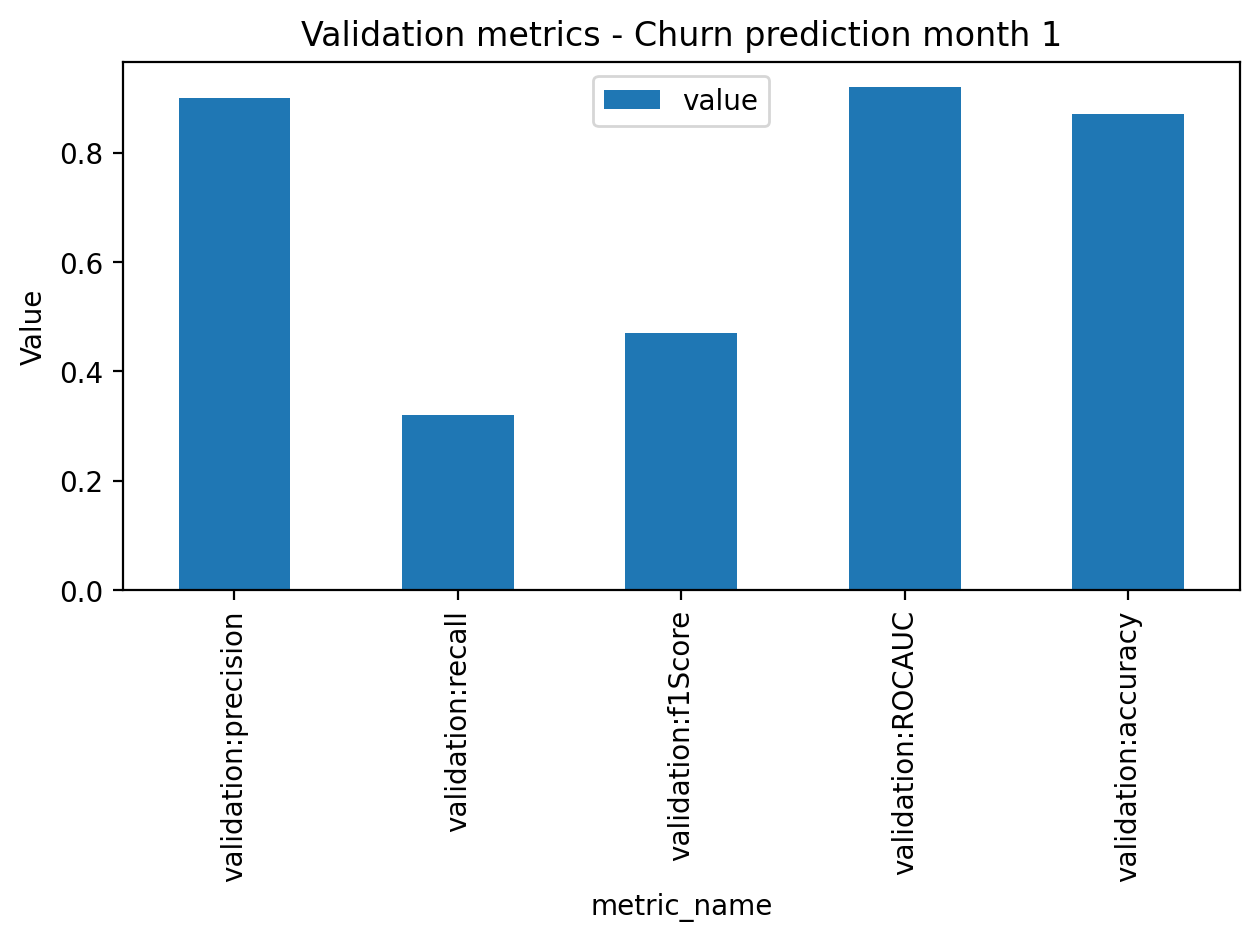

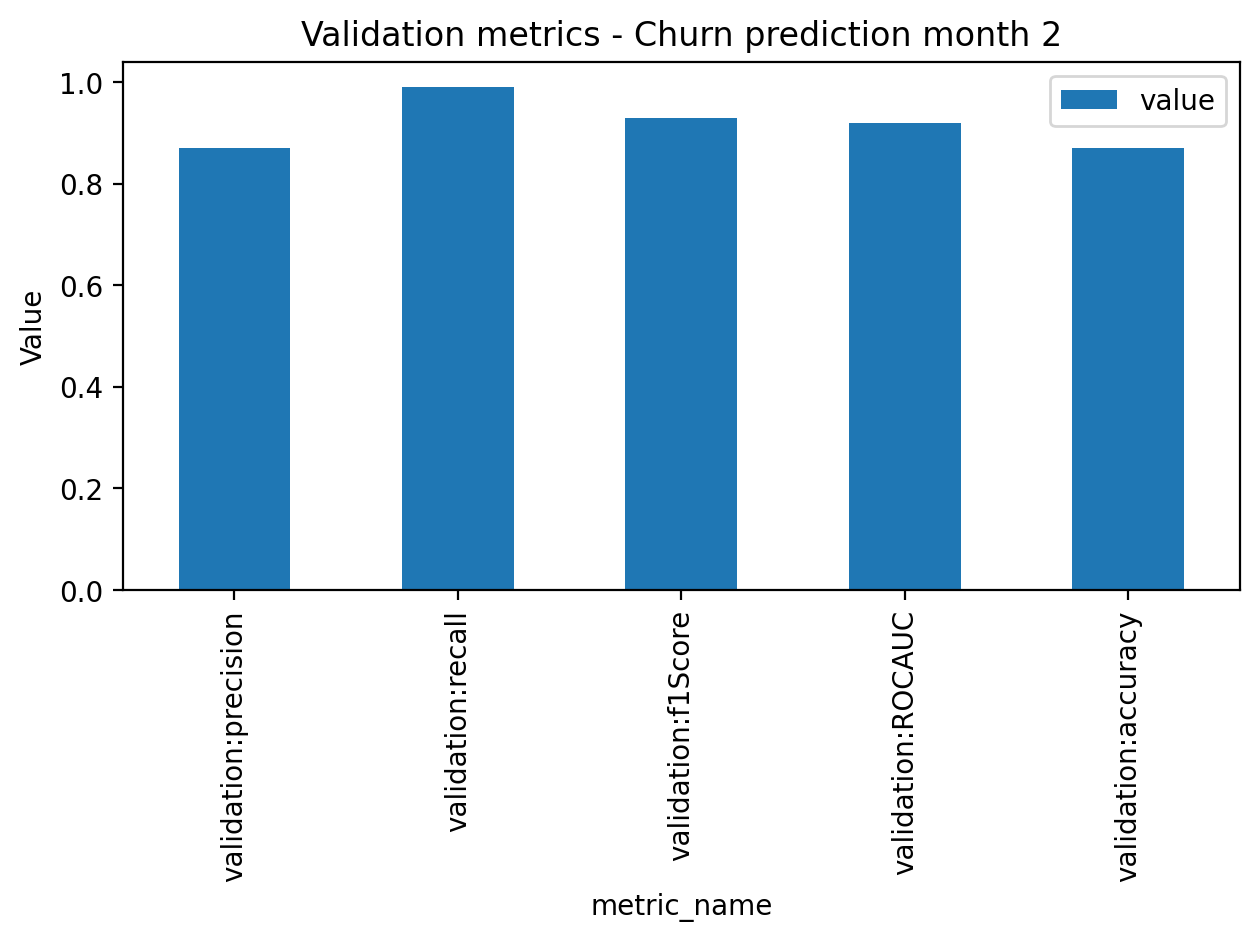

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'


for estimator in [sklearn_estimator_mon1, sklearn_estimator_mon2]:
    
    training_job = estimator.latest_training_job.describe()
    churn_mon = training_job['HyperParameters'].get('churn_month')
    print(training_job['TrainingJobName'])
    
    df_metrics = estimator.training_job_analytics.dataframe()
    df_metrics.loc[df_metrics.metric_name=='validation:accuracy', 'value'] /= 100

    
    display(df_metrics)
    df_metrics.plot.bar(x='metric_name', y='value', 
                        title='Validation metrics - Churn prediction month {}'.format(churn_mon), 
                        ylabel='Value')
    
    plt.tight_layout();

In [55]:
!aws s3 cp ./TrainingJob.ipynb s3://$bucket/Training-Job-without-debugger/TrainingJob.ipynb
!aws s3 cp ./train.py s3://$bucket/Training-Job-without-debugger/train.py

upload: ./TrainingJob.ipynb to s3://sagemaker-eu-west-3-668303144976/Training-Job-without-debugger/TrainingJob.ipynb
upload: ./train.py to s3://sagemaker-eu-west-3-668303144976/Training-Job-without-debugger/train.py


# 2. Hyperparameters Tuning Job 
___
## 2.1 Setup hyperparameters

In [89]:
hyperparameters_static_mon1 = {
    'churn_month': churn_mon1,
    'random_state': random_state
}

hyperparameters_static_mon2 = {
    'churn_month': churn_mon2,
    'random_state': random_state
}

In [90]:
from sagemaker.parameter import CategoricalParameter, ContinuousParameter, IntegerParameter


hyperparameter_ranges = {
    'n_estimators': IntegerParameter(min_value=100, 
                                     max_value=200, 
                                     scaling_type='Logarithmic'),
    
    'max_depth': IntegerParameter(min_value=3, 
                                  max_value=10, 
                                  scaling_type='Auto'),
    
    'criterion': CategoricalParameter(values=['gini', 'entropy'])
}

In [91]:
metric_definitions = [
    {'Name': 'validation:precision', 'Regex': 'val_precision: ([0-9.]+)'},
    {'Name': 'validation:recall', 'Regex': 'val_recall: ([0-9.]+)'},
    {'Name': 'validation:f1Score', 'Regex': 'val_f1score: ([0-9.]+)'},
    {'Name': 'validation:ROCAUC', 'Regex': 'val_roc_auc: ([0-9.]+)'},
    {'Name': 'validation:accuracy', 'Regex': 'val_accuracy: ([0-9.]+)'}
]

## 2.2 Instanciate & fit estimators

In [92]:
from sagemaker.sklearn.estimator import SKLearn


sklearn_estimator_mon1 = SKLearn(
    entry_point='train.py',
    framework_version=FRAMEWORK_VERSION,
    instance_count=instance_count,
    instance_type=instance_type,
    role=role,
    metric_definitions=metric_definitions,
    hyperparameters=hyperparameters_static_mon1,
)


sklearn_estimator_mon2 = SKLearn(
    entry_point='train.py',
    framework_version=FRAMEWORK_VERSION,
    instance_count=instance_count,
    instance_type=instance_type,
    role=role,
    metric_definitions=metric_definitions,
    hyperparameters=hyperparameters_static_mon2,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [93]:
from sagemaker.tuner import HyperparameterTuner


objective_metric = 'validation:accuracy'
tuning_strategy = 'Bayesian'

tuner_mon1 = HyperparameterTuner(
    estimator=sklearn_estimator_mon1,
    objective_metric_name=objective_metric,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    strategy=tuning_strategy,
    objective_type='Maximize',
    max_jobs=12,                # maximum number of jobs to run
    max_parallel_jobs=2,        # maximum number of jobs to run in parallel
    early_stopping_type='Auto'  # early stopping criteria
)


tuner_mon2 = HyperparameterTuner(
    estimator=sklearn_estimator_mon2,
    objective_metric_name=objective_metric,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    strategy=tuning_strategy,
    objective_type='Maximize',
    max_jobs=12,                # maximum number of jobs to run
    max_parallel_jobs=2,        # maximum number of jobs to run in parallel
    early_stopping_type='Auto'  # early stopping criteria
)

In [95]:
print('Running hyperparameters tuning for {} metric'.format(objective_metric))
print('-----------------------------\n')


tuner_mon1.fit(
    inputs=data_channels,
    include_cls_metadata=False,
    wait=False
)


tuner_mon2.fit(
    inputs=data_channels,
    include_cls_metadata=False,
    wait=False
)

## 2.3 Tuning job analytics

In [100]:
months = ('Month1')
tuners = (tuner_mon1,)
tuning_results = {}

for month, tuner in zip(months, tuners):
    print('Displaying hyperparameters tuning results for {} churn prediction'.format(month))
    print('-----------------------------\n')
    
    df_results = tuner.analytics().dataframe()
    display(df_results.sort_values('FinalObjectiveValue', ascending =False))

    tuning_results[month] = df_results

Displaying hyperparameters tuning results for M churn prediction
-----------------------------



,criterion,max_depth,n_estimators,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""entropy""",10.0,100.0,sagemaker-scikit-lea-231118-1806-012-e54c14dd,Completed,93.709999,2023-11-18 18:15:12+00:00,2023-11-18 18:15:49+00:00,37.0
1,"""entropy""",9.0,100.0,sagemaker-scikit-lea-231118-1806-011-0a41095c,Completed,93.459999,2023-11-18 18:14:26+00:00,2023-11-18 18:15:03+00:00,37.0
2,"""entropy""",10.0,200.0,sagemaker-scikit-lea-231118-1806-010-251a5e47,Completed,93.459999,2023-11-18 18:14:17+00:00,2023-11-18 18:14:59+00:00,42.0
5,"""entropy""",10.0,104.0,sagemaker-scikit-lea-231118-1806-007-716828bb,Completed,93.459999,2023-11-18 18:12:12+00:00,2023-11-18 18:12:53+00:00,41.0
11,"""entropy""",10.0,191.0,sagemaker-scikit-lea-231118-1806-001-53361d4c,Completed,93.459999,2023-11-18 18:08:17+00:00,2023-11-18 18:09:59+00:00,102.0
6,"""gini""",10.0,100.0,sagemaker-scikit-lea-231118-1806-006-f04d8bc6,Completed,93.459999,2023-11-18 18:11:50+00:00,2023-11-18 18:12:27+00:00,37.0
4,"""gini""",10.0,193.0,sagemaker-scikit-lea-231118-1806-008-2d0b8fac,Completed,93.339996,2023-11-18 18:13:27+00:00,2023-11-18 18:14:08+00:00,41.0
3,"""gini""",10.0,136.0,sagemaker-scikit-lea-231118-1806-009-26f9e4a2,Completed,93.089996,2023-11-18 18:13:16+00:00,2023-11-18 18:13:58+00:00,42.0
10,"""entropy""",6.0,162.0,sagemaker-scikit-lea-231118-1806-002-548c0fa6,Completed,91.000000,2023-11-18 18:08:12+00:00,2023-11-18 18:09:49+00:00,97.0
7,"""gini""",5.0,172.0,sagemaker-scikit-lea-231118-1806-005-10fd83b6,Completed,90.510002,2023-11-18 18:11:00+00:00,2023-11-18 18:11:42+00:00,42.0


## 2.4 Best candidate

In [101]:
from pprint import pprint


tuning_description = {}

for month, tuner in zip(months, tuners):
    print('Displaying hyperparameters tuning results for {} churn prediction'.format(month))
    print('-----------------------------\n')
    
    df_results = tuner.analytics().dataframe()
    best_candidate = df_results.sort_values('FinalObjectiveValue', ascending =False).iloc[0]
    
    tuning_description[month] = {
        'TrainingJobName': best_candidate['TrainingJobName'],
        'FinalObjectiveValue': best_candidate['FinalObjectiveValue'],
        'Hyperparameters': best_candidate[list(hyperparameter_ranges.keys())].to_dict()
    }

pprint(tuning_description)

Displaying hyperparameters tuning results for M churn prediction
-----------------------------

{'M': {'FinalObjectiveValue': 93.70999908447266,
       'Hyperparameters': {'criterion': '"entropy"',
                           'max_depth': 10.0,
                           'n_estimators': 100.0},
       'TrainingJobName': 'sagemaker-scikit-lea-231118-1806-012-e54c14dd'}}


In [104]:
# ========================== Second Method =========================
tuning_description2 = {}

for month, tuner in zip(months, tuners):
    print('Displaying hyperparameters tuning results for {} churn prediction'.format(month))
    print('-----------------------------\n')
    
    tuning_description2[month] = tuner.describe().get('BestTrainingJob')
    pprint(tuning_description2[month])

Displaying hyperparameters tuning results for M churn prediction
-----------------------------

{'CreationTime': datetime.datetime(2023, 11, 18, 18, 15, 8, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:accuracy',
                                                 'Value': 93.70999908447266},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2023, 11, 18, 18, 15, 49, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:eu-west-3:668303144976:training-job/sagemaker-scikit-lea-231118-1806-012-e54c14dd',
 'TrainingJobName': 'sagemaker-scikit-lea-231118-1806-012-e54c14dd',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2023, 11, 18, 18, 15, 12, tzinfo=tzlocal()),
 'TunedHyperParameters': {'criterion': '"entropy"',
                          'max_depth': '10',
                          'n_estimators': '100'}}


# 3. Tuning & debugging Sagemaker built-in algorithm - Xgboost
___

In [ ]:
# Next steps:
#     - Debugger and Profiler
#     - Using Sagemaker Xgboost built-in algorithm
#     - Model evaluation
#     - Pipelines

## 3.1 Configure data channels

In [3]:
from sagemaker.inputs import TrainingInput


train_data_s3_uri = 's3://{}/sagemaker-scikit-learn-2023-11-13-11-46-50-760/output/bank-churn-train/'.format(bucket)
validation_data_s3_uri = 's3://{}/sagemaker-scikit-learn-2023-11-13-11-46-50-760/output/bank-churn-validation/'.format(bucket)


data_channels = {
    'train': TrainingInput(s3_data=train_data_s3_uri, content_type='text/csv'),
    'validation': TrainingInput(s3_data=validation_data_s3_uri, content_type='text/csv')
}

## 3.2 Configure Estimator parameters

In [11]:
instance_count = 1
instance_type = 'ml.m5.large'

prefix = 'xgboost-churn'
xgboost_output_path = 's3://{}/{}/xgboost-estimator-training-job'.format(bucket, prefix)

xgboost_static_hyperparameters = {
    'num_class': 2,
    'booster': 'gbtree',
    'early_stopping_rounds': 20,
    'seed': 2023,
    'verbosity': 1
}

## 3.3 Configure tunable hyperparameters

In [5]:
metric_definitions = [
    {'Name': 'validation:precision', 'Regex': 'val_precision: ([0-9.]+)'},
    {'Name': 'validation:recall', 'Regex': 'val_recall: ([0-9.]+)'},
    {'Name': 'validation:f1Score', 'Regex': 'val_f1score: ([0-9.]+)'},
    {'Name': 'validation:ROCAUC', 'Regex': 'val_roc_auc: ([0-9.]+)'},
    {'Name': 'validation:accuracy', 'Regex': 'val_accuracy: ([0-9.]+)'}
]

In [6]:
# ======================= Configure hyperparameters tuning =======================
from sagemaker.parameter import CategoricalParameter, ContinuousParameter, IntegerParameter


hyperparameter_ranges = {
    # Tree depth
    'max_depth': IntegerParameter(min_value=1, 
                                 max_value=5, 
                                 scaling_type='Auto'),
    
    # Number of boosting rounds
    'num_round': IntegerParameter(min_value=500, 
                                 max_value=2000, 
                                 scaling_type='Auto'),
    
    
    # L1 Regularization
    'alpha': ContinuousParameter(min_value=0, 
                                 max_value=10, 
                                 scaling_type='Auto'),
    
    # L2 Regularization
    'gamma': ContinuousParameter(min_value=0, 
                                 max_value=100, 
                                 scaling_type='Auto')
}

## 3.4 Configure Sagemaker Debugger & Profiler

In [8]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig
from sagemaker.debugger import ProfilerConfig, FrameworkProfile


# ========================== Debugger configuration =========================
debugger_hook_config = DebuggerHookConfig(
    s3_output_path='s3://{}/{}/xgboost-estimator-training-job/debugger-report'.format(bucket, prefix)
)


# ========================== Profiler configuration =========================
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(local_path="/opt/ml/output/profiler/", start_step=5, num_steps=10)
)


# ============================ Rules configuration ==========================
rules = [
    # Debugger
    Rule.sagemaker(rule_configs.confusion()),
    Rule.sagemaker(rule_configs.feature_importance_overweight()),
    Rule.sagemaker(rule_configs.tree_depth()),
    Rule.sagemaker(rule_configs.create_xgboost_report()),
    
    # Profiler
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


## 3.4 Retrieve Xgboost image & instanciate estimator

In [12]:
from sagemaker.estimator import Estimator


# ========================= Instanciate Xgboost estimator ========================
xgboost_image_uri = sagemaker.image_uris.retrieve("xgboost", region, "1.7-1")

xgboost_estimator = Estimator(image_uri=xgboost_image_uri,
                              role=role,
                              instance_count=instance_count,
                              instance_type=instance_type,
                              output_path=xgboost_output_path,
                              sagemaker_session=sess,
                              hyperparameters=xgboost_static_hyperparameters,
                              rules=rules,
                              debugger_hook_config=debugger_hook_config ,
                              profiler_config=profiler_config)


# ====================== Fit without hyperparameters tuning ======================
# xgboost_estimator.fit(inputs=data_channels,
#                      wait=False,
#                      logs='All')

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [15]:
from sagemaker.tuner import HyperparameterTuner

objective_metric = 'validation:f1'
tuning_strategy = 'Bayesian'

tuner_xgboost = HyperparameterTuner(
    estimator=xgboost_estimator,
    objective_metric_name=objective_metric,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    strategy=tuning_strategy,
    objective_type='Maximize',
    max_jobs=12,                # maximum number of jobs to run
    max_parallel_jobs=1,        # maximum number of jobs to run in parallel
    early_stopping_type='Auto'  # early stopping criteria
)

In [17]:
tuner_xgboost.fit(inputs=data_channels,
                  wait=False)

In [24]:
from pprint import pprint

tuner_xgboost.describe().keys()

dict_keys(['HyperParameterTuningJobName', 'HyperParameterTuningJobArn', 'HyperParameterTuningJobConfig', 'TrainingJobDefinition', 'HyperParameterTuningJobStatus', 'CreationTime', 'LastModifiedTime', 'TrainingJobStatusCounters', 'ObjectiveStatusCounters', 'TuningJobCompletionDetails', 'ConsumedResources', 'ResponseMetadata'])

In [ ]:
tuner_xgboost.describe().get('HyperParameterTuningJobStatus')